In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops
from tensorflow import keras
import random
import math


%matplotlib inline
np.random.seed(1)

In [44]:
def diabetes_data():
    
    # load data
    df = pd.read_csv('diabetic_data.csv')
    df = df.replace('?', np.nan)
    
    # take only patients who were discharged home or to nursing care facilities
    df = df.loc[df.discharge_disposition_id.isin([1,3,4,6,8,22,24])]
    
    # code the target variable into three classes
    target = pd.get_dummies(df['readmitted'])
    df = pd.concat([df, target], axis = 1)
    
    # pick only top 10 medical specialities and group the rest as "other"
    df['medical_specialty'] = df['medical_specialty'].fillna('UNK')
    df['med_spec'] = df['medical_specialty'].copy()
    top_10 = ['UNK', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Nephrology', 
           'Orthopedics', 'Orthopedics-Reconstructive', 'Radiologist']
    df.loc[~df.med_spec.isin(top_10), 'med_spec'] = 'Other'
    
    # turn age into numeric
    df['age_num'] = df['age'].copy()
    age_num = {'[0-10)':0,  '[10-20)':1,
           '[20-30)':2, '[30-40)':3,
           '[40-50)':4, '[50-60)':5,
           '[60-70)':6, '[60-70)':6,
           '[70-80)':7, '[80-90)':8,
           '[90-100)':9}
    df = df.replace(age_num)
    
    # turn weight into binary: if the weight was measured or not
    df['has_weight'] = df.weight.notnull().astype('int')
    
    # take numerical columns
    cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses','age_num','has_weight']

    # scale numerical columns
    df[cols_num] = df[cols_num].apply(lambda x: x/x.max(), axis=0)
    
    # turn indexed variables into strings
    indexed = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
    df[indexed] = df[indexed].astype('str')
    
    # process categorical columns intu dummy variables 
    cols_cat = ['race', 'gender',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'med_spec'] 
    df['race'] = df['race'].fillna('UNK')
    df['payer_code'] = df['payer_code'].fillna('UNK')
    df_cat = pd.get_dummies(df[cols_cat])
    df = pd.concat([df, df_cat], axis = 1)
    cols_cat = list(df_cat.columns)
    
    all_data = pd.concat([df[cols_cat + cols_num], target], axis = 1)
    
    #shuffle data
    all_data = all_data.sample(n=len(all_data), random_state = 1)
    all_data = all_data.reset_index(drop=True)
    
#     scaler = StandardScaler()
#     scaler.fit(all_data)
#     all_data = scaler.transform(all_data)

    return (all_data[:45000], all_data[45001:])

In [198]:
def gene_data():
    
    df_X = pd.read_csv('gene_data.csv', index_col=0)
    df_Y = pd.read_csv('gene_labels.csv', index_col=0)
    
    # encode classes as dummy variables and concatenate with features for shuffling and sampling
    target = pd.get_dummies(df_Y['Class'])
    all_data = pd.concat([df_X, target], axis = 1)
    
    #shuffle data
    all_data = all_data.sample(n=len(all_data), random_state = 1)
    all_data = all_data.reset_index(drop=True)
    
    return (all_data[:400], all_data[400:])

In [211]:
def mnist_data():
    mnist = keras.datasets.mnist
    (X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = mnist.load_data()
    
    # Flatten
    X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1)
    X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1)
    
    # Normalize image vectors
    X_train = X_train_flatten/255.
    X_test = X_test_flatten/255.
    
    # Convert training and test labels to one hot matrices
    y_train = np.squeeze(np.eye(10)[y_train_orig.reshape(-1)])
    y_test = np.squeeze(np.eye(10)[y_test_orig.reshape(-1)])        
    
    return (X_train, y_train, X_test, y_test)

# Get data and cast it into network-digestable format

In [387]:
def get_data(data): 
    if data == 'diabetes':
        data, shadow = diabetes_data()
        # split data into train and test
        class_names = ['<30', '>30', 'NO']
        y = data[class_names]
        X = data.drop(class_names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1)

    elif data == 'gene':
        data, shadow = gene_data()
        class_names = ['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']
        y = data[class_names]
        X = data.drop(class_names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=1)
    
    elif data == 'mnist':
        (X_train, y_train, X_test, y_test) = mnist_data()
        
        # Take half of training tada as target set
        y_train = y_train[:30000]
        X_train = X_train[:30000]
    
    elif data == 'mnist_shadow':
        (X_train, y_train, X_test, y_test) = mnist_data()
        
        # Take second half of training data as shadow dataset
        y_shadow = y_train[30000:]
        X_shadow = X_train[30000:]
        
        # Split it in half to form training and test shadow sets
        X_train, X_test, y_train, y_test = train_test_split(X_shadow, y_shadow, test_size = 0.5, random_state=1)
        
    # cast dataframes to numpy arrays and transpose for easier use in tensorflow

    X_train = np.array(X_train).T
    X_test = np.array(X_test).T
    Y_train = np.array(y_train).T
    Y_test = np.array(y_test).T
        
                                                                        
    print ("number of training examples = " + str(X_train.shape[1]))
    print ("number of test examples = " + str(X_test.shape[1]))
    print ("X_train shape: " + str(X_train.shape))
    print ("Y_train shape: " + str(Y_train.shape))
    print ("X_test shape: " + str(X_test.shape))
    print ("Y_test shape: " + str(Y_test.shape))
    
    return X_train, Y_train, X_test, Y_test                                             

In [399]:
X_train_tg, Y_train_tg, X_test_tg, Y_test_tg = get_data('mnist')
X_train, Y_train, X_test, Y_test = get_data('mnist_shadow')

number of training examples = 30000
number of test examples = 10000
X_train shape: (784, 30000)
Y_train shape: (10, 30000)
X_test shape: (784, 10000)
Y_test shape: (10, 10000)
number of training examples = 15000
number of test examples = 15000
X_train shape: (784, 15000)
Y_train shape: (10, 15000)
X_test shape: (784, 15000)
Y_test shape: (10, 15000)


Cost after epoch 0: 0.980189


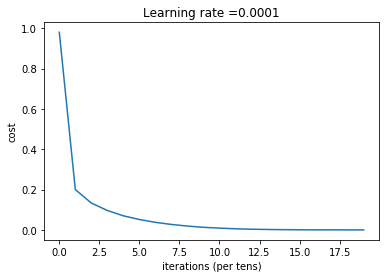

Parameters have been trained!
Train Accuracy: 0.9975
Test Accuracy: 0.967


In [409]:
parameters_tg = model(X_train_tg, Y_train_tg, X_test_tg, Y_test_tg)

Cost after epoch 0: 1.380558


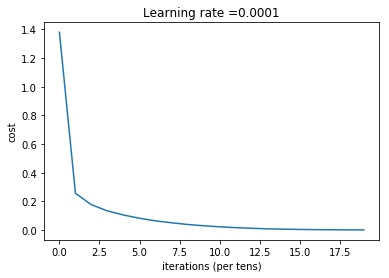

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9564


In [401]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [417]:
X_train_adv, Y_train_adv, X_test_adv, Y_test_adv = get_adversary()

number of training examples = 30000
number of test examples = 30000
X_train shape: (30000, 20)
Y_train shape: (30000,)
X_test shape: (30000, 20)
Y_test shape: (30000,)


In [416]:
def get_adversary():
    # turn softmax of training examples into a dataframe
    df1 = pd.DataFrame(get_softmax(X_train, parameters).T)
    # add true classes 
    true1 = pd.DataFrame(Y_train.T)
    df1 = pd.concat([df1, true1], axis=1)
    # label as 1
    df1['label'] = 1
    # turn softmax of unseen examples into a dataframe
    df2 = pd.DataFrame(get_softmax(X_test, parameters).T)
    true2 = pd.DataFrame(Y_test.T)
    # add true classes
    df2 = pd.concat([df2, true2], axis=1)
    # label as 0
    df2['label'] = 0
    # combine
    df = pd.concat([df1, df2], axis=0)
    # shuffle
    df = df.sample(n=len(df), random_state = 1)
    df = df.reset_index(drop=True)
    
    # Get prediction vectors from a target set
    X_target, Y_target, __, __, = mnist_data()
    X_target = X_target[:30000].T
    target_soft = get_softmax(X_target, parameters_tg)
    
    #construct training and test set for adversarial model
    X = df.copy()
    y = X.pop('label')
    #y = np.array(y).reshape(y.shape[0], 1)
    X_train_adv = np.array(X)
    Y_train_adv = np.array(y)
    Y_test_adv = np.ones(30000,)
    X_test_adv = np.concatenate([target_soft.T, Y_target[:30000]], axis=1)
    
    print ("number of training examples = " + str(X_train_adv.shape[0]))
    print ("number of test examples = " + str(X_test_adv.shape[0]))
    print ("X_train shape: " + str(X_train_adv.shape))
    print ("Y_train shape: " + str(Y_train_adv.shape))
    print ("X_test shape: " + str(X_test_adv.shape))
    print ("Y_test shape: " + str(Y_test_adv.shape))
    
    return X_train_adv, Y_train_adv, X_test_adv, Y_test_adv

In [430]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#clf = SVC(gamma='auto').fit(X_train_adv, Y_train_adv)
clf = LogisticRegression(random_state=1).fit(X_train_adv, Y_train_adv)

clf.score(X_train_adv, Y_train_adv)

0.5098666666666667

In [27]:
# data, shadow = gene_data()
# y = shadow[['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD']]
# x = shadow.drop(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], axis=1)
# X_test = np.array(x).T
# Y_test = np.array(y).T
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

In [28]:
# from pandas dataset directly to tf.slices
# training_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(X_train.values, tf.float32), tf.cast(y_train.values, tf.int32)))

In [248]:
def get_softmax(X, parameters):
    X_p = tf.placeholder(tf.float32, [X.shape[0], None], name = "X")
    softmax = forward_propagation(X_p, parameters)
    init = tf.global_variables_initializer()
    #auc = tf.metrics.auc(Y, Z3)

    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        softmax = sess.run(softmax, feed_dict = {X_p:X})
        return softmax

# Build a simple model

## Utility functions


In [327]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    
    return X, Y

def initialize_parameters(n_x, n_y):
    
    tf.set_random_seed(1)
        
    
    W1 = tf.get_variable("W1", [125, n_x], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [125, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [25, 125], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [25, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_y, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [n_y, 1], initializer = tf.zeros_initializer())
    

    parameters = {
                  "W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3'] 
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                               # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                               # Z3 = np.dot(W3,Z2) + b3

    
    return Z3

def compute_cost(Z3, Y):
    
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


## Building the model

In [328]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 20531, number of training examples = 340)
    Y_train -- test set, of shape (output size = 5, number of training examples = 340)
    X_test -- training set, of shape (input size = 20531, number of training examples = 60)
    Y_test -- test set, of shape (output size = 5, number of test examples = 60)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_y)
 
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        try:
            with open('Log/'+datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
                print("Train size: {}, learning rate: {}, num_epochs: {}, minibatch_size: {}"
                      .format(m, learning_rate, num_epochs, minibatch_size), file=log)
                print(costs, file=log)
                print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}), file=log)
                print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}), file=log)
                
        except IOError:
                print('File Error')
        
        return parameters

In [219]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, Z3)


0.9946666666666668

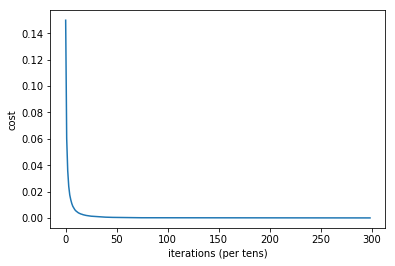

In [32]:
costs = [[0.14989176765084267, 0.060277315229177474, 0.03595366030931473, 0.023983438499271873, 0.01745189605280757, 0.013734755944460629, 0.01087184278294444, 0.008805390307679772, 0.007496933359652757, 0.006190448207780719, 0.005323010263964534, 0.0046829227590933446, 0.004106839234009385, 0.0036365702981129293, 0.00328261632239446, 0.002942966762930155, 0.0027493090368807317, 0.0024384532123804094, 0.0022333250613883137, 0.002050547185353935, 0.001881442219018936, 0.0017507830169051885, 0.0016297990456223487, 0.001502217573579401, 0.0014034926891326905, 0.0013059162127319723, 0.0012478824704885484, 0.001131330127827823, 0.001062267174711451, 0.0009966448997147381, 0.0009360875294078143, 0.0008899502863641828, 0.0008391951967496426, 0.0007901425298769027, 0.0007418035180307925, 0.0007062352175125851, 0.0006745069986209273, 0.0006298350694123654, 0.0005971108417725191, 0.0005693562125088647, 0.000536208279663697, 0.000514672408462502, 0.0004885634436504916, 0.0004748494538944215, 0.00045830216840840875, 0.000426047807559371, 0.00040596932522021236, 0.00039315836329478765, 0.00036763414100278165, 0.000353683611319866, 0.0003443802299443632, 0.0003196996622136794, 0.0003083549148868769, 0.0003024954901775345, 0.0002884966699639335, 0.000274467290728353, 0.00025981987128034236, 0.0002496937697287649, 0.00023794224471203053, 0.00023348353715846315, 0.00022032041888451204, 0.00021229424746707084, 0.00021052141746622508, 0.00019742797740036623, 0.00019710431952262296, 0.00018254767492180692, 0.00017378153934259903, 0.0001668456563493237, 0.00016334916581399738, 0.00015474168976652435, 0.0001528471417259425, 0.00014456370481639172, 0.0001423524176061619, 0.00013688045364688148, 0.0001298547053011134, 0.0001292083616135642, 0.00011984628326899839, 0.00011832518721348606, 0.00011432711326051504, 0.00011290185902907977, 0.0001054774234944489, 0.00010076590187964031, 9.767161536728963e-05, 9.572102972015273e-05, 9.147991004283538e-05, 8.912669072742574e-05, 8.589551398472397e-05, 8.311171768582426e-05, 8.087011337920559e-05, 7.701110771449749e-05, 7.406189470202661e-05, 7.166895993577783e-05, 6.907357710588258e-05, 7.018758078629617e-05, 6.499743612948805e-05, 6.380421582434792e-05, 6.355695513775572e-05, 5.921499578107613e-05, 5.776900325145107e-05, 5.608612264040858e-05, 5.340091938705882e-05, 5.2613400112022655e-05, 5.087007848487701e-05, 4.885740236204583e-05, 4.697677250078414e-05, 4.604539280990139e-05, 4.400166963023366e-05, 4.3014845869038264e-05, 4.3801227184303565e-05, 4.0173973866330924e-05, 3.918196525773965e-05, 3.776417561311973e-05, 3.6191938306728844e-05, 3.531208822096232e-05, 3.43334559147479e-05, 3.390562505956041e-05, 3.311818727524951e-05, 3.1701471198175564e-05, 3.0376829454326074e-05, 2.926699107774766e-05, 2.8516146630863656e-05, 2.809136094583664e-05, 2.6944438832288143e-05, 2.578723706392339e-05, 2.5811798332142642e-05, 2.4549758927605583e-05, 2.360755397603498e-05, 2.293190545969992e-05, 2.2896582868270345e-05, 2.243029821329401e-05, 2.097635979225743e-05, 2.03156716452213e-05, 2.0002723067591434e-05, 1.9090139358013402e-05, 1.8954828192363497e-05, 1.7913839838001876e-05, 1.80459094735852e-05, 1.733738972689025e-05, 1.6718779806979e-05, 1.611179286555853e-05, 1.573936770000728e-05, 1.546256407891633e-05, 1.4897422897774957e-05, 1.4088919442656334e-05, 1.3987164766149365e-05, 1.3536714277506691e-05, 1.316420311923139e-05, 1.253517511941027e-05, 1.209918527820264e-05, 1.2055530942234326e-05, 1.1443930407040171e-05, 1.1109415936516598e-05, 1.0927031371466e-05, 1.0684599419619189e-05, 1.0348070100008043e-05, 9.898071812131094e-06, 9.730440797284244e-06, 9.2794702595711e-06, 9.250859284293255e-06, 8.995317830340354e-06, 8.637027531221974e-06, 8.647228423797059e-06, 8.108573956633337e-06, 7.942579441078123e-06, 7.64344604249345e-06, 7.539214630014613e-06, 7.256100843733294e-06, 6.893190266055172e-06, 6.755507843081432e-06, 6.6896487396661535e-06, 6.569991137439501e-06, 6.174823556648334e-06, 6.029167298038374e-06, 5.775330237156595e-06, 5.809080562357848e-06, 5.5397483265551274e-06, 5.4326131476045704e-06, 5.207161916587211e-06, 5.044294834988249e-06, 4.957198598276591e-06, 4.792320214619394e-06, 4.627218140740297e-06, 4.484839314500278e-06, 4.404524906931328e-06, 4.355501073405321e-06, 4.244711385581468e-06, 4.014343880953674e-06, 3.891559276780754e-06, 3.77443784600473e-06, 3.691812571560149e-06, 3.4910957310785303e-06, 3.5132988841724e-06, 3.316605648251425e-06, 3.253723480156623e-06, 3.167595593822625e-06, 3.107395798451762e-06, 2.9871448646190403e-06, 2.8668935215137028e-06, 2.772570246634132e-06, 2.699927756566467e-06, 2.724066303017025e-06, 2.5875741130221288e-06, 2.503010750842805e-06, 2.5158254175039472e-06, 2.3727758616587383e-06, 2.2975256342760985e-06, 2.2099071657066816e-06, 2.1508247300516812e-06, 2.1526129785343073e-06, 2.0674537267950655e-06, 1.983188087706367e-06, 1.9120354863844113e-06, 1.928575261445076e-06, 1.8493021343601865e-06, 1.7583311432645133e-06, 1.7315839329512527e-06, 1.6458280185815967e-06, 1.6015717335449152e-06, 1.5529198321928562e-06, 1.544351795246257e-06, 1.4543491488439031e-06, 1.437287517092045e-06, 1.4223119706002763e-06, 1.3557784825479756e-06, 1.374106653884155e-06, 1.2820926826861976e-06, 1.2573568767493271e-06, 1.2303113351208596e-06, 1.1721971588940507e-06, 1.1357639607467717e-06, 1.1274939168970375e-06, 1.0696031097268134e-06, 1.0724343269430394e-06, 1.0053794142095284e-06, 9.691697613334327e-07, 9.832512034790851e-07, 9.340031454030394e-07, 9.048715071457991e-07, 8.939936890328682e-07, 8.625522895044923e-07, 8.269386626125197e-07, 8.082377362939041e-07, 7.684517896677789e-07, 7.508684518597873e-07, 7.286657819349783e-07, 7.170429313418936e-07, 6.884327746092823e-07, 6.756923227158042e-07, 6.62057743738842e-07, 6.280087120558165e-07, 6.165348366948819e-07, 5.923949800035189e-07, 5.754821970072043e-07, 5.567068086520521e-07, 5.421036973984884e-07, 5.340570879752704e-07, 5.110348354264716e-07, 5.010510875536056e-07, 4.770602359371879e-07, 4.691626585895393e-07, 4.60594479534393e-07, 4.3779575094049504e-07, 4.2766298662400005e-07, 4.1373042165560036e-07, 4.023310495426812e-07, 3.997978524239443e-07, 3.7647756556680184e-07, 3.679839181813805e-07, 3.556159768436373e-07, 3.430990091146669e-07, 3.327427265276129e-07, 3.2179037674495707e-07, 3.211198290387074e-07, 3.1240266622489794e-07, 3.0025822610468823e-07, 2.90348967268983e-07, 2.8386696584448143e-07, 2.7857706541567495e-07, 2.6799724963666447e-07, 2.6307986331630675e-07, 2.6799723542580976e-07, 2.4236727256266024e-07, 2.3424614639111494e-07, 2.3104240085558555e-07, 2.3223448977205408e-07, 2.2202720302288982e-07, 2.1427860588119075e-07, 2.0645550833364723e-07, 2.0399681730509658e-07, 1.9974998934912947e-07, 1.9274644387223815e-07, 1.855938918993161e-07, 1.8164508830409432e-07, 1.7553561661998177e-07, 1.7181032703206258e-07, 1.6488129332969948e-07, 1.636892022816028e-07, 1.6130502231703758e-07, 1.481920053336694e-07]]
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()